# Example mean field game system solution

In [76]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np


power = 4
params = {
        'n_dims': 2,
        'dim_sizes': np.array([8, 16]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

def prepare_model(border_weight, colloc_weight, connect_weights):
    eps = 0.01

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]
    # border_weight = 1
    # no_need_weight = 0


    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],])
                                
    border_points = connect_points


    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                                u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2*colloc_weight,

                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2*colloc_weight ,
                                                                                                ]


    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))
                                                            ) * w**2*colloc_weight,
                            lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,0],1),  u_loc([0,0],1))) * w**2*colloc_weight,
                            ]
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 12 * (sm_x**2) *(1-sm_x)
        else:
            return 0

    def terminal_state(x):
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 12*sm_x*(1-sm_x)**2
        else:
            return 0

    small = 1e-5

    border_left_operators = [
        lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
        lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,0]+small)*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
        lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],0) * border_weight,
        ]

    border_right_operators = [
        lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
        lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,0]+small) * (terminal_state(x[1])) * border_weight, #* no_need_weight,
        lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,0]+small) * initial_state(x) * border_weight, # border and initial cond for s
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = connect_points
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)
    for func_num in range(sol.n_funcs):
        connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num))]
        connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num))]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }


    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [77]:
weights = {'border_weight':1, 
'colloc_weight':1, 
'connect_weights':[10,10]
}
sol, iteration_dict = prepare_model(**weights)
# A, b = sol.solve(solver = 'SVD', **iteration_dict, verbose=True)

In [71]:
A, b = sol.global_solve(solver = 'np', **iteration_dict, calculate = True, return_system=True, alpha = 0, verbose=True)

In [78]:
import copy
k=200
n=20
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array

# for i in range(5):
for j in range(k):
    prev_eval = eval(sol)
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', svd_threshold=1e-8, return_system=True, **iteration_dict)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.sum(np.abs(prev_eval - eval(sol))))

0  |  1.6790848401590088  |  146.94788582392124
1  |  1.2862214250002355  |  19.709835031081415
2  |  1.4855582512837882  |  73.07731172961621
3  |  0.5353792025459537  |  32.73824067401444
4  |  0.49532275755945676  |  33.23520372974679
5  |  0.47966010311731266  |  25.90002822867014
6  |  0.18679539735840486  |  8.483859447032776
7  |  0.10108898707573966  |  7.904617380053543
8  |  0.1559704664280046  |  9.980314049688033
9  |  0.21528077838029924  |  11.136455682961767
10  |  0.20810528167051068  |  13.4194182442998
11  |  0.10715651555743799  |  8.805888616311039


KeyboardInterrupt: 

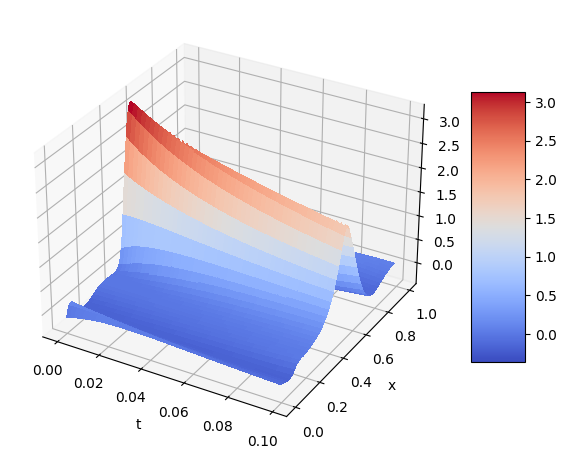

In [79]:
sol.plot2d()

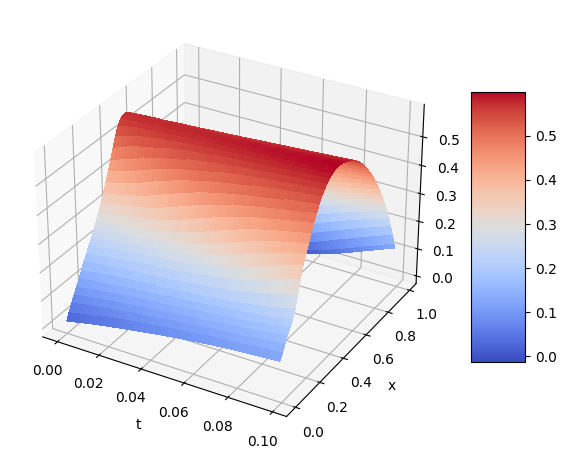

In [80]:
sol.plot2d(func_num=1)

## Weights experiments

In [4]:
n=4
cweight_list = [2**i for i in range(n)]

bweight_list = [2**i for i in range(n)]

conditions = np.empty((n,n))

for bw, i in  zip(bweight_list, range(n)):
    for cw, j in zip(cweight_list, range(-2, n-2)):
        weights = {'border_weight':bw, 
        'colloc_weight':cw, 
        'connect_weights':[1,1]
        }
        sol, iteration_dict = prepare_model(**weights)
        A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
        conditions[i,j] = np.linalg.cond(A)

KeyboardInterrupt: 

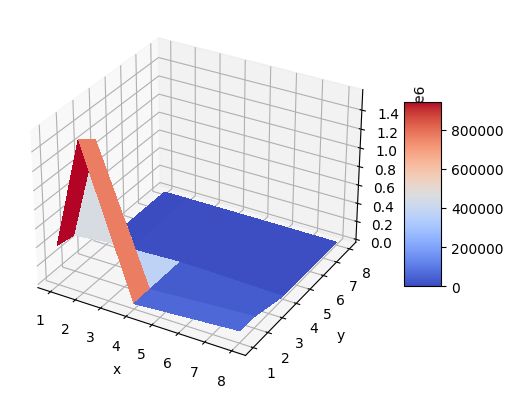

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
X, Y = np.meshgrid(bweight_list, cweight_list)
surf = ax.plot_surface(X,Y,  conditions, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [6]:
weights = {'border_weight':200,
'colloc_weight':1.5,
'connect_weights':np.array([200,10]) * 0.75
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
np.linalg.cond(A)

2063.431741718855

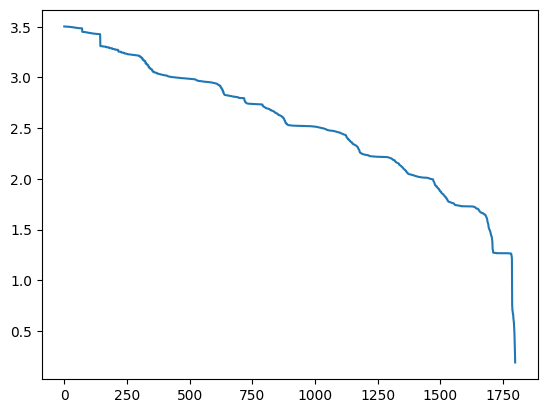

In [7]:
_, s, __ = np.linalg.svd(A)
plt.plot(np.log(s)/np.log(10))

In [29]:
#simple direct problem solving 

import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

a = 1
b = 1

eps = 0.01

power = 5
params = {
    'n_dims': 2,
    'dim_sizes': np.array([6, 6]),
    'area_lims': np.array([[0,0.1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 2,
}
sol = Solution(**params)

w = 1
k1 = 1
k2 = 1
border_weight = 1
no_need_weight = 0


def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points


colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                              u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                             u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                             u_bas([0,0],0)*u_loc([0,2],1))
                                                                                          ) * w**2,

                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                             +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                            ) * w**2 ,
                                                                                            ]


def popravka(f,g):
    return f*g
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))
                                                         ) * w**2,
                          lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,0],1),  u_loc([0,0],1))) * w**2,
                          ]
colloc_ops = [colloc_left_operators, colloc_right_operators]


def initial_state(x):
    t, x = x
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return 12 * (sm_x**2) *(1-sm_x)
    else:
        return 0

def terminal_state(x):
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return 12*sm_x*(1-sm_x)**2
    else:
        return 0

small = 1e-5

border_left_operators = [
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
    lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,0]+small)*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],0) * border_weight,
    ]

border_right_operators = [
    lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
    lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,0]+small) * (terminal_state(x[1])) * border_weight, #* no_need_weight,
    lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,0]+small) * initial_state(x) * border_weight, # border and initial cond for s
]

border_ops = [border_left_operators, border_right_operators]

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
points=[colloc_points, connect_points ,border_points]

connect_left_operators = []
connect_right_operators = []

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point))
    return np.array(direction, dtype=int)
for func_num in range(sol.n_funcs):
    connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
    connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
       'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0



import copy
k=200
n=20
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array

r = np.array((k *sol.cells_coefs.shape))
# for i in range(5):
for j in range(k):
    prev_eval = eval(sol)
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', svd_threshold=1e-8, return_system=True, alpha = 0, **iteration_dict)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - eval(sol))))

0  |  1.598314232335926  |  1.6926372272631132
1  |  1.4495769612720164  |  0.054280961998262045
2  |  1.8022450425507797  |  1.7753780968417527
3  |  0.6623479880183276  |  0.7228384283489167
4  |  1.0671638887007628  |  0.4405132108619494
5  |  0.4989056707789631  |  0.2998217275694579
6  |  0.6552290830213598  |  0.41049466829988845
7  |  0.2022280918548488  |  0.14330782281832766
8  |  0.187526995145164  |  0.20509684586643573
9  |  0.33625646952930577  |  0.3119238610056474
10  |  0.16640078763408472  |  0.13410093311093751
11  |  0.09427913943985619  |  0.09684323594860433
12  |  0.45131930789683805  |  0.35579551103760476
13  |  0.3368765541867825  |  0.2798210531431411
14  |  0.1816194835588868  |  0.16857880465699715
15  |  0.1999454969602506  |  0.1390121766600818
16  |  0.24374496101309517  |  0.1772522754703274
17  |  0.14681467622988512  |  0.10190805252315223
18  |  0.14959103983953712  |  0.12154677448792622
19  |  0.15214343164552185  |  0.1432364188227644
20  |  0.2481

KeyboardInterrupt: 

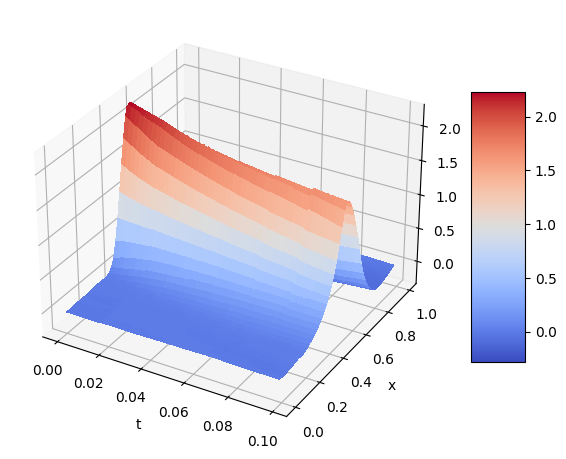

In [30]:
sol.plot2d()

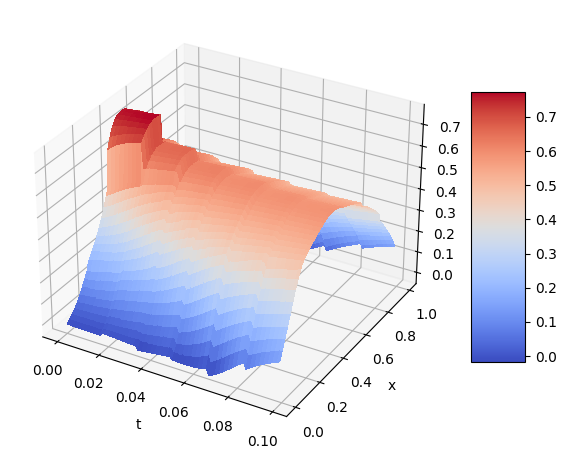

In [31]:
sol.plot2d(func_num=1)